In [1]:
# https://openrouteservice.org/
# https://openrouteservice.org/dev/#/api-docs/v2/directions/{profile}/get

# username = dconly
# email = dconly@sacog.org

import requests
import os

import pandas as pd 
import geopandas as gpd
import arcpy
from arcgis.features import GeoAccessor, GeoSeriesAccessor
arcpy.env.overwriteOutput = True

api_key_source = r"C:\Users\dconly\GitRepos\GIS-tools\ORS\api2_DO_NOT_COMMIT.txt"
with open(api_key_source) as f:
    ors_api_key = f.readline()







In [2]:
# Make isochrone around multiple points along a line
# https://openrouteservice.org/dev/#/api-docs/isochrones

# input project line feature class
line_fc = r"I:\Projects\Darren\PEP\PEP_GIS\PEP_GIS.gdb\test_sr51"
sref_wgs84 = arcpy.SpatialReference(4326)


# make temporary feature class of points at regular intervales along lines
# FYI, time permitting, the shapely library has some options for doing this that *might* be faster than ESRI tool
temp_pt_fc = os.path.join(arcpy.env.scratchGDB, "TEMP_pts")
arcpy.management.GeneratePointsAlongLines(line_fc, 
                                          temp_pt_fc, "DISTANCE", 
                                          Distance="1000 feet", 
                                          Include_End_Points="END_POINTS")

# calc x/y coords in WGS84 (WKID 4326) for compatibility with ORS API
pt_fl = "pt_fl"
arcpy.MakeFeatureLayer_management(temp_pt_fc, pt_fl)
arcpy.AddGeometryAttributes_management(Input_Features=pt_fl, 
                                       Geometry_Properties=['POINT_X_Y_Z_M'],
                                      Coordinate_System=sref_wgs84)

# print([f.name for f in arcpy.ListFields(temp_pt_fc)])

# make array of points at regular intervals along line to
line_pts = []
with arcpy.da.SearchCursor(pt_fl, ["POINT_X", "POINT_Y"]) as cur:
    for row in cur:
        lon = row[0]
        lat = row[1]
        pt_coords = [lon, lat]
        line_pts.append(pt_coords)
        
# batchify points into groups of 5, because ORS API cannot process more than 5 points in single call

line_pts_batched = [line_pts[i:i+5] for i, v in enumerate(line_pts) if i % 5 == 0]
# line_pts_batched
print("Done.")


                    



Done.


In [4]:
# generate isochrones around each of those points
max_time_mins = 15
max_time_sec = max_time_mins * 60
travel_mode = "driving-car" # "driving-car" #"foot-walking"

gdf_master = gpd.GeoDataFrame()

# Go through each batch of 5 points and draw an isochrone around them, then combine all the batches together
# into 1 geodatframe with all relevant isochrone polygons in it. Next step would then be dissolve all polygons.
for pts_batch in line_pts_batched:

    body = {"locations":pts_batch, "range":[max_time_sec], "range_type":"time"}

    headers = {
        'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
        'Authorization': ors_api_key,
        'Content-Type': 'application/json; charset=utf-8'
    }

    call = requests.post(f'https://api.openrouteservice.org/v2/isochrones/{travel_mode}', json=body, headers=headers)

    polygon_json = call.json()['features']
    
    gdf_batch = gpd.GeoDataFrame.from_features(polygon_json) # FYI, as of 12/12/2021, geopandas read_file() does not work due to a fiona compatibility issue.
    gdf_batch['dissolve_col'] = 0
    gdf_master = gdf_master.append(gdf_batch)
    
print('master geopandas gdf created')
    
# gdf_master.head(14)
# gdf.plot(cmap='Set1')



master geopandas gdf created


<AxesSubplot:>

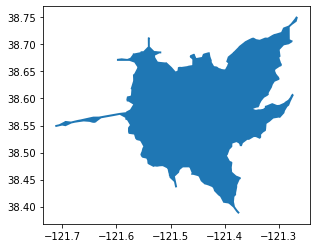

In [5]:
# Dissolve the multiple polygons into single polygon using Geopandas
gdf_diss = gdf_master.dissolve(by='value')

gdf_diss.plot()

In [6]:
# export to ESRI feature class
out_file = r'I:\Projects\Darren\PPA3_GIS\PPA3Testing.gdb\TEST_from_SEDF'

sedf = pd.DataFrame.spatial.from_geodataframe(gdf_diss)


In [7]:
# attempt to convert SEDF directly to feature class
# As of 12/19/2021, there is issue in which none of the SEDF's features are writing out to the feature class.
# Darren wrote about it at https://community.esri.com/t5/arcgis-api-for-python-questions/converting-spatially-enabled-dataframe-to-feature/m-p/1127417
sedf.spatial.to_featureclass(out_file)
arcpy.management.GetCount(out_file)[0] # test to see if anything wrote out to feature class

'0'

In [32]:
# SEDF > featureset > geojson file > feature class

featureset = sedf.spatial.to_featureset()
temp_geojson = os.path.join(arcpy.env.scratchFolder, "TEMP.geojson")
with open(temp_geojson, "w", encoding="utf-8") as file:
    file.write(featureset.to_geojson)
    

test_fc = r'I:\Projects\Darren\PPA3_GIS\PPA3Testing.gdb\test_fc'

arcpy.conversion.JSONToFeatures(temp_geojson, test_fc)
os.remove(temp_geojson)

arcpy.management.GetCount(test_fc)[0]



'1'

In [8]:
# Plot on webmap
from arcgis import GIS
gis = GIS()

m1 = gis.map(location = 'Sacramento, CA', zoomlevel = 12)
sedf.spatial.plot(map_widget=m1)
m1

MapView(layout=Layout(height='400px', width='100%'))

In [17]:
# SEDF > featureset > feature class
# https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#featureset

fs2 = sedf.spatial.to_featureset()
fs2.save(save_location="I:\Projects\Darren\PPA3_GIS\PPA3Testing.gdb", out_name='TEST_output_fromFS')

'I:\\Projects\\Darren\\PPA3_GIS\\PPA3Testing.gdb\\TEST_output_fromFS'

In [20]:
test_fc = r'I:\Projects\Darren\PPA3_GIS\PPA3Testing.gdb\test_fc'
os.path.basename(test_fc)

'test_fc'